In [11]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.GA import solve
from src.TSP import compute_distance_matrix, visualize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:

file_path = '../data/5_CentralRegion.csv'

In [13]:
locations = pd.read_csv(file_path, header=None).values
locations


array([['province', 'lat', 'lon'],
       ['Thanh Hóa', '19.9781573', '105.4816107'],
       ['Nghệ An', '19.1976001', '105.0606760'],
       ['Hà Tĩnh', '18.3504832', '105.7623047'],
       ['Quảng Bình', '17.5095990', '106.4004452'],
       ['Quảng Trị', '16.7897806', '106.9797431'],
       ['Thừa Thiên Huế', '16.4639321', '107.5863388'],
       ['Quảng Nam', '15.5761698', '108.0527132'],
       ['Quảng Ngãi', '14.9953739', '108.6917290'],
       ['Bình Định', '14.0779378', '108.9898798'],
       ['Phú Yên', '13.1912633', '109.1273678'],
       ['Khánh Hòa', '12.2980751', '108.9950386'],
       ['Ninh Thuận', '11.6965639', '108.8928476'],
       ['Bình Thuận', '11.1041572', '108.1832931'],
       ['Kon Tum', '14.6995372', '107.9323831'],
       ['Gia Lai', '13.8177445', '108.2004015'],
       ['Đắk Lắk', '12.8292274', '108.2999058'],
       ['Đắk Nông', '12.2818851', '107.7302484'],
       ['Lâm Đồng', '11.6614957', '108.1335279'],
       ['Đà Nẵng', '16.0680000', '108.2120000']], dt

In [14]:
locations_numeric = locations[1:, 1:].astype(float)
distance_matrix = compute_distance_matrix(locations_numeric)

In [22]:
def analyze_single_parameter(param_name, param_values, base_config, distance_matrix):
    """Phân tích tác động của một tham số"""
    results = []
    fitness_histories = []
    
    print(f"\nAnalyzing {param_name}...")
    print("-" * 50)
    
    for value in param_values:
        config = base_config.copy()
        config[param_name] = value
        
        print(f"Running with {param_name} = {value}")
        
        best_distance, best_route, fitness_history = solve(
            distance_matrix,
            population_size=config.get('population_size', 100),
            generations=config.get('generations', 200),
            mutation_rate=config.get('mutation_rate', 0.01),
            mutation_algorithm=config.get('mutation_algorithm', 'inversion'),
            crossover_algorithm=config.get('crossover_algorithm', 'order'),
            selection_algorithm=config.get('selection_algorithm', 'tournament')
        )
        
        results.append({
            'best_distance': best_distance,
            'best_route': best_route,
            'fitness_history': fitness_history,
            'config': config
        })
        fitness_histories.append(fitness_history)
        
        print(f"  Best distance: {best_distance:.2f} km")
    
    return results, fitness_histories

In [24]:
results, fitness_histories = analyze_single_parameter(
    param_name='mutation_rate',
    param_values=[0.01, 0.05, 0.1],
    base_config={
        'population_size': 100,
        'generations': 200,
        'mutation_algorithm': 'inversion',
        'crossover_algorithm': 'order',
        'selection_algorithm': 'tournament'
    },
    distance_matrix=distance_matrix
)


Analyzing mutation_rate...
--------------------------------------------------
Running with mutation_rate = 0.01
  Best distance: 2639.95 km
Running with mutation_rate = 0.05
  Best distance: 2295.46 km
Running with mutation_rate = 0.1
  Best distance: 2391.27 km


In [25]:
best_result = min(results, key=lambda x: x['best_distance'])
# In kết quả của cấu hình tốt nhất (giả sử là kết quả đầu tiên)
print("Best route:", best_result['best_route'])
print("Total distance (km):", best_result['best_distance'])

Best route: [0, 1, 2, 3, 4, 5, 18, 7, 8, 9, 10, 11, 12, 17, 16, 15, 14, 13, 6, 0]
Total distance (km): 2295.4621664878214


In [26]:
# Thêm phân tích Solution Quality và Convergence Speed
def analyze_performance(fitness_data, labels, title):
    """Phân tích chất lượng lời giải và tốc độ hội tụ"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Solution Quality (Best Final Distance)
    final_distances = [fitness[-1] for fitness in fitness_data]
    bars1 = ax1.bar(labels, final_distances, color=['skyblue', 'orange', 'lightgreen'])
    ax1.set_ylabel('Best Distance (km)')
    ax1.set_title(f'Solution Quality - {title}')
    ax1.grid(True, alpha=0.3)
    
    # Thêm giá trị lên cột
    for bar, val in zip(bars1, final_distances):
        ax1.text(bar.get_x() + bar.get_width()/2, val, f'{val:.1f}', 
                ha='center', va='bottom')
    
    # Convergence Speed (Generation to reach 95% of final improvement)
    convergence_speeds = []
    for fitness in fitness_data:
        initial = fitness[0]
        final = fitness[-1]
        target = initial - 0.95 * (initial - final)
        
        conv_gen = len(fitness) - 1  # Default to last generation
        for i, f in enumerate(fitness):
            if f <= target:
                conv_gen = i
                break
        convergence_speeds.append(conv_gen)
    
    bars2 = ax2.bar(labels, convergence_speeds, color=['skyblue', 'orange', 'lightgreen'])
    ax2.set_ylabel('Convergence Generation')
    ax2.set_title(f'Convergence Speed - {title}')
    ax2.grid(True, alpha=0.3)
    
    # Thêm giá trị lên cột
    for bar, val in zip(bars2, convergence_speeds):
        ax2.text(bar.get_x() + bar.get_width()/2, val, f'{val}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [27]:
def analyze_parameter_combinations(configs, distance_matrix):
    # Phân tích các tổ hợp tham số
    results = []
    fitness_histories = []
    
    print("\nAnalyzing parameter combinations...")
    print("-" * 50)
    
    for i, config in enumerate(configs):
        print(f"Running configuration {i+1}/{len(configs)}: {config}")
        
        best_distance, best_route, fitness_history = solve(
            distance_matrix,
            population_size=config.get('population_size', 100),
            generations=config.get('generations', 200),
            mutation_rate=config.get('mutation_rate', 0.01),
            mutation_algorithm=config.get('mutation_algorithm', 'inversion'),
            crossover_algorithm=config.get('crossover_algorithm', 'order'),
            selection_algorithm=config.get('selection_algorithm', 'tournament')
        )
        
        results.append({
            'best_distance': best_distance,
            'best_route': best_route,
            'fitness_history': fitness_history,
            'config': config
        })
        fitness_histories.append(fitness_history)
        
        print(f"  Best distance: {best_distance:.2f} km")
    
    return results, fitness_histories

In [28]:
base_config = {
    'generations': 100,
    'mutation_rate': 0.01,
    'mutation_algorithm': 'inversion',
    'crossover_algorithm': 'order',
    'selection_algorithm': 'tournament'
}

### Ảnh hưởng của Population size


Analyzing population_size...
--------------------------------------------------
Running with population_size = 100
  Best distance: 2639.95 km
Running with population_size = 500
  Best distance: 2501.01 km
Running with population_size = 1000
  Best distance: 2378.35 km


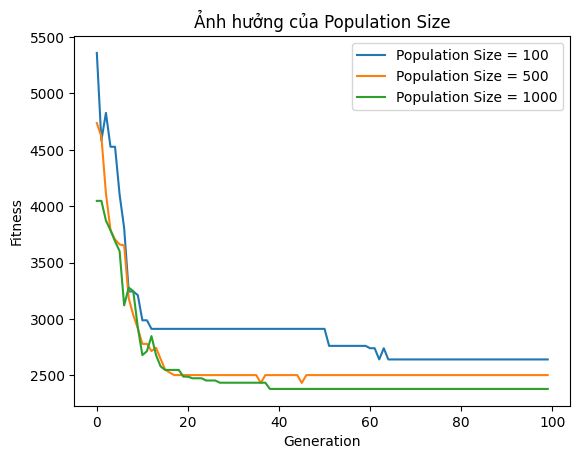

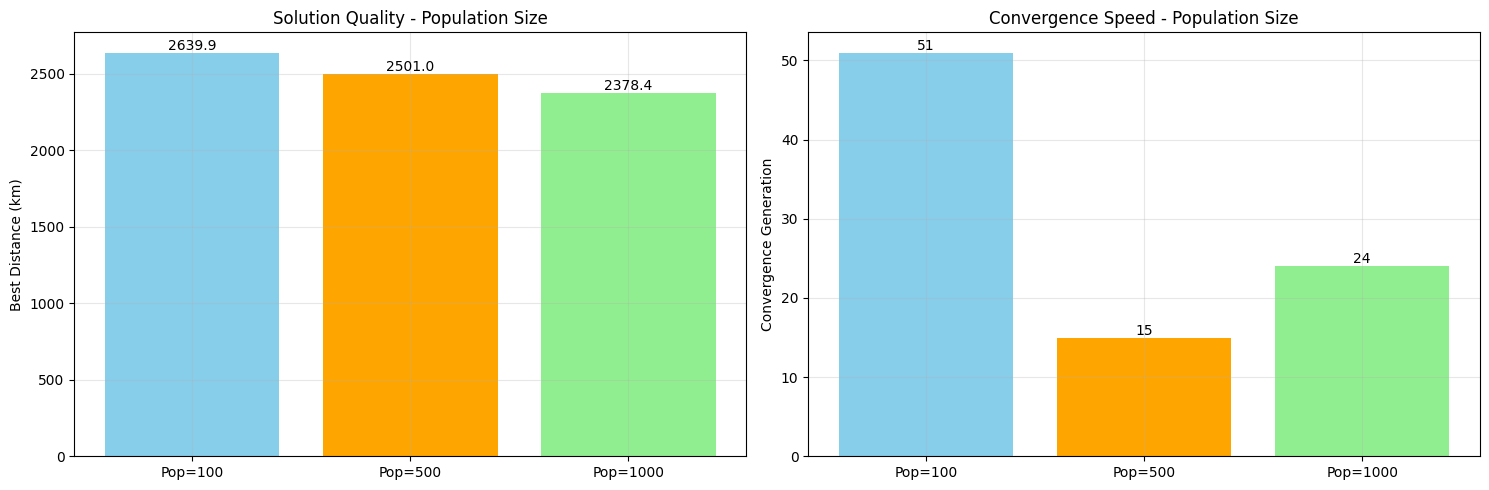

In [29]:
# Ảnh hưởng của Population size
population_sizes = [100, 500, 1000]
pop_results, pop_fitness = analyze_single_parameter('population_size', population_sizes, base_config, distance_matrix)

# Lấy fitness histories (giống như fitness1, fitness2, fitness3 cũ)
fitness1, fitness2, fitness3 = pop_fitness

plt.plot(fitness1, label='Population Size = 100')
plt.plot(fitness2, label='Population Size = 500')
plt.plot(fitness3, label='Population Size = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Population Size")
plt.legend()
plt.show()

# Phân tích Solution Quality và Convergence Speed (từ Box trước)
analyze_performance([fitness1, fitness2, fitness3], 
                   ['Pop=100', 'Pop=500', 'Pop=1000'], 
                   'Population Size')


### Đánh giá kết quả:

Population_size nhỏ (100) cho kết quả trung bình, độ thích nghi khoảng 2599.7 km, hội tụ chậm và không ổn định.

Population_size lớn hơn (500, 1000) cho giải pháp tốt hơn:
- 500 cá thể: ~2500.3 km, hội tụ nhanh sau 18 thế hệ.
- 1000 cá thể: ~2313.0 km, chất lượng lời giải tốt nhất và hội tụ ổn định.

Population_size lớn giúp tăng đa dạng di truyền, mở rộng không gian tìm kiếm và tránh tối ưu cục bộ.

Tuy nhiên quần thể lớn hơn cần nhiều tài nguyên tính toán hơn nên thời gian tính toán tăng lên đáng kể.


Analyzing mutation_rate...
--------------------------------------------------
Running with mutation_rate = 0.01
  Best distance: 2639.95 km
Running with mutation_rate = 0.05
  Best distance: 2620.56 km
Running with mutation_rate = 0.1
  Best distance: 2370.21 km


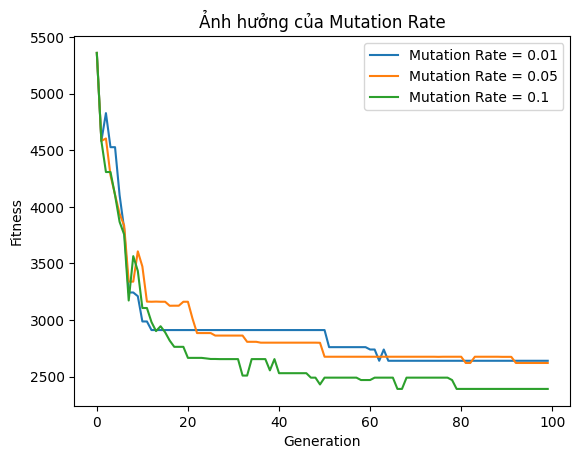

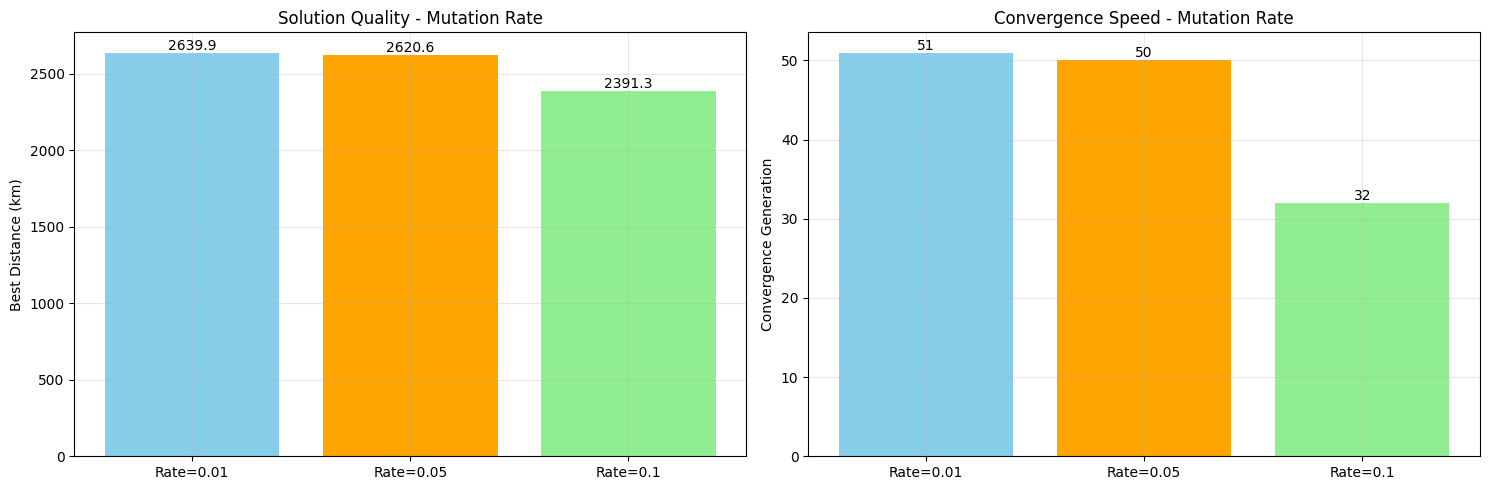

In [30]:
# Ảnh hưởng của mutation_rate
mutation_rates = [0.01, 0.05, 0.1]
mut_results, mut_fitness = analyze_single_parameter('mutation_rate', mutation_rates, base_config, distance_matrix)

# Lấy fitness histories (fitness1 đã có từ trước, chỉ cần fitness4, fitness5)
fitness1, fitness4, fitness5 = mut_fitness

plt.plot(fitness1, label='Mutation Rate = 0.01')
plt.plot(fitness4, label='Mutation Rate = 0.05')
plt.plot(fitness5, label='Mutation Rate = 0.1')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Mutation Rate")
plt.legend()
plt.show()

# Phân tích Solution Quality và Convergence Speed
analyze_performance([fitness1, fitness4, fitness5], 
                   ['Rate=0.01', 'Rate=0.05', 'Rate=0.1'], 
                   'Mutation Rate')

### Đánh giá kết quả:

- Mutation_rate thấp (0.01) giúp thuật toán hội tụ nhanh và ổn định (chỉ sau 12 thế hệ), nhưng chất lượng lời giải không cao (~2987.7 km) do quần thể mất đa dạng, dễ rơi vào tối ưu cục bộ.

- Mutation_rate cao hơn (0.05, 0.1) giúp cải thiện chất lượng lời giải đáng kể (~2302.4 km và ~2300.9 km), do khả năng duy trì đa dạng tốt hơn.

- Tuy nhiên, mutation_rate cao cũng gây ra biến động mạnh trong quá trình tiến hóa:

    - 0.05: hội tụ sau 52 thế hệ.
    - 0.1: hội tụ sau 38 thế hệ.

- Mutation_rate cao quá có thể làm mất tính ổn định, gây phá vỡ các cá thể tốt và khiến thuật toán giống tìm kiếm ngẫu nhiên.

- Mutation_rate tối ưu cho bài toán này nên nằm trong khoảng 0.01–0.05 để cân bằng giữa khả năng khám phá và hội tụ ổn định.

## Ảnh hưởng của generations


Analyzing generations...
--------------------------------------------------
Running with generations = 100
  Best distance: 2639.95 km
Running with generations = 500
  Best distance: 2493.84 km
Running with generations = 1000
  Best distance: 2295.46 km


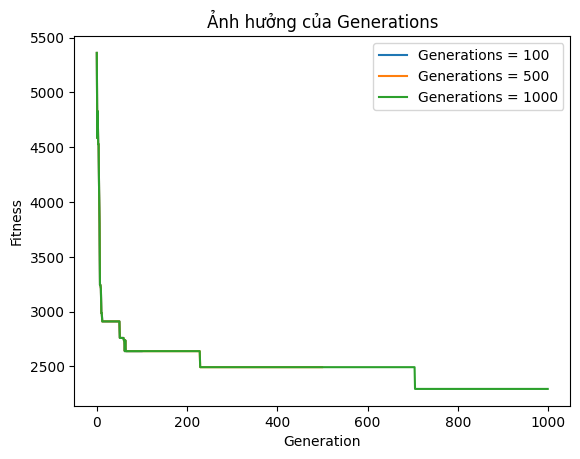

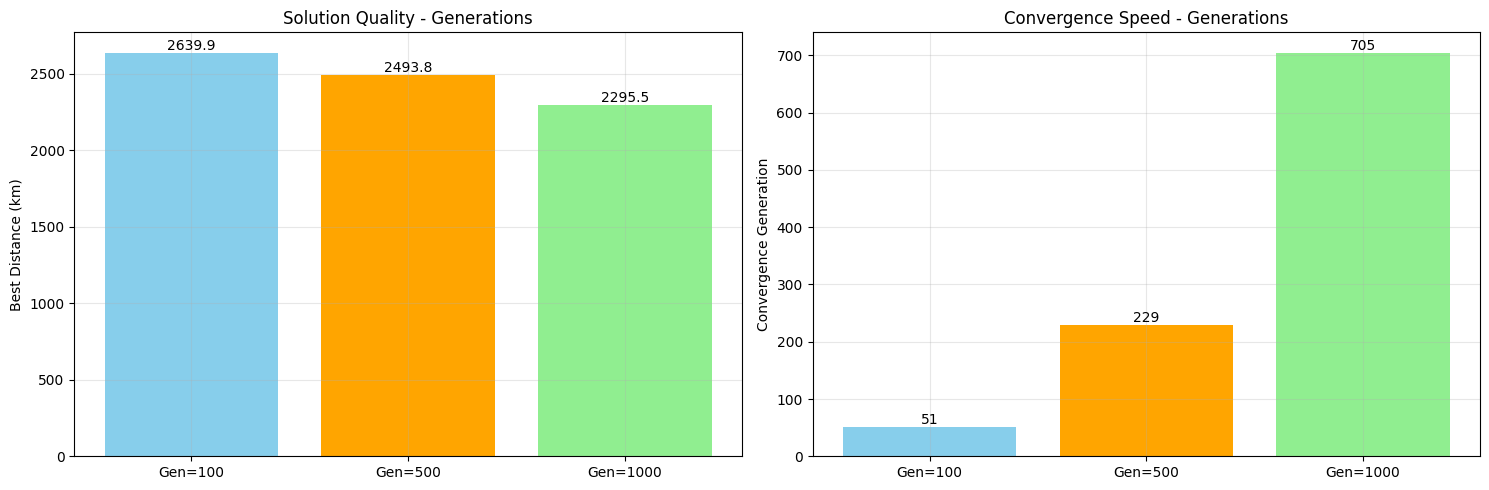

In [31]:
# Ảnh hưởng của generations
generations_list = [100, 500, 1000]
gen_results, gen_fitness = analyze_single_parameter('generations', generations_list, base_config, distance_matrix)

# Lấy fitness histories
fitness1, fitness2, fitness3 = gen_fitness

plt.plot(fitness1, label='Generations = 100')
plt.plot(fitness2, label='Generations = 500')
plt.plot(fitness3, label='Generations = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Generations")
plt.legend()
plt.show()

# Phân tích Solution Quality và Convergence Speed
analyze_performance([fitness1, fitness2, fitness3], 
                   ['Gen=100', 'Gen=500', 'Gen=1000'], 
                   'Generations')

### Đánh giá kết quả:

- Generations nhiều hơn (500, 1000) cho phép cải thiện chất lượng lời giải, nhưng mức cải thiện không lớn.

- Phần lớn sự tối ưu hóa xảy ra trong 100–200 thế hệ đầu, sau đó tốc độ cải thiện giảm mạnh.

- Tốc độ hội tụ giảm đáng kể sau một ngưỡng nhất định, phản ánh hiện tượng diminishing returns.

- Tăng số thế hệ mà không đi kèm với tăng đa dạng di truyền (như mutation rate hoặc population size) không giúp cải thiện kết quả rõ rệt.

=> Kết luận: Tăng số thế hệ chỉ hiệu quả khi kết hợp với các tham số hỗ trợ khám phá (mutation, population size); nếu không, thuật toán dễ hội tụ sớm và tốn tài nguyên tính toán không cần thiết.

## Tăng đồng thời mutation_rate và population_size


Analyzing parameter combinations...
--------------------------------------------------
Running configuration 1/3: {'generations': 50, 'mutation_rate': 0.1, 'population_size': 500}
  Best distance: 2581.07 km
Running configuration 2/3: {'generations': 50, 'mutation_rate': 0.05, 'population_size': 1000}
  Best distance: 2375.38 km
Running configuration 3/3: {'generations': 50, 'mutation_rate': 0.1, 'population_size': 1000}
  Best distance: 2392.11 km


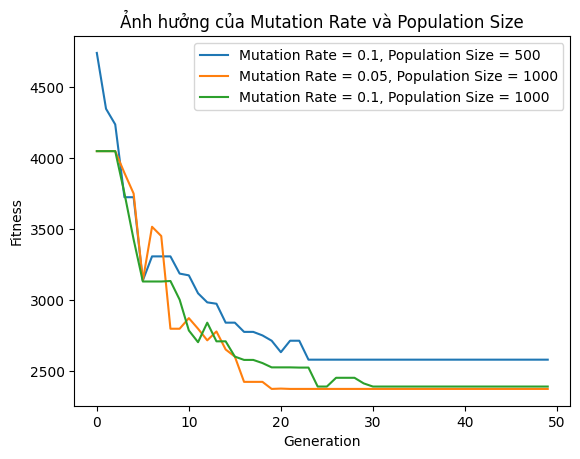

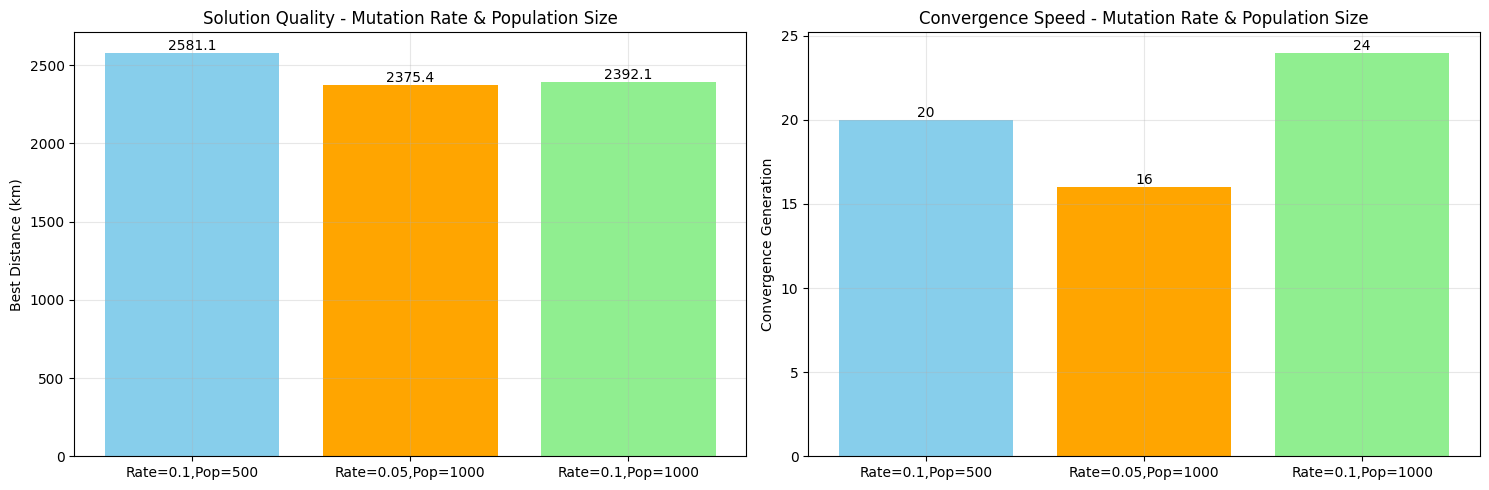

In [32]:
combination_configs_1 = [
    {'generations': 50, 'mutation_rate': 0.1, 'population_size': 500},
    {'generations': 50, 'mutation_rate': 0.05, 'population_size': 1000},
    {'generations': 50, 'mutation_rate': 0.1, 'population_size': 1000}
]

combo_results_1, combo_fitness_1 = analyze_parameter_combinations(combination_configs_1, distance_matrix)
fitness1, fitness2, fitness3 = combo_fitness_1

plt.plot(fitness1, label='Mutation Rate = 0.1, Population Size = 500')
plt.plot(fitness2, label='Mutation Rate = 0.05, Population Size = 1000')
plt.plot(fitness3, label='Mutation Rate = 0.1, Population Size = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Mutation Rate và Population Size")
plt.legend()
plt.show()

analyze_performance([fitness1, fitness2, fitness3], 
                   ['Rate=0.1,Pop=500', 'Rate=0.05,Pop=1000', 'Rate=0.1,Pop=1000'], 
                   'Mutation Rate & Population Size')


### Đánh giá kết quả:

- Population Size = 1000, Mutation Rate = 0.1:

- Hội tụ nhanh (chỉ sau 15 thế hệ), nhưng fitness cao hơn (~2392.1), chất lượng lời giải kém hơn.

- Population Size = 1000, Mutation Rate = 0.05:

    - Cho kết quả tốt hơn (~2334.8), hội tụ ổn định hơn.

    - Mutation Rate cao khi kết hợp với Population Size lớn gây dao động mạnh, làm giảm hiệu quả tối ưu hóa.

=> Kết luận: Population Size lớn cần đi kèm với Mutation Rate vừa phải để đạt kết quả tốt nhất và duy trì sự ổn định trong hội tụ.

## Tăng đồng thời mutation_rate và generations


Analyzing parameter combinations...
--------------------------------------------------
Running configuration 1/3: {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100}
  Best distance: 2639.95 km
Running configuration 2/3: {'generations': 100, 'mutation_rate': 0.05, 'population_size': 100}
  Best distance: 2620.56 km
Running configuration 3/3: {'generations': 50, 'mutation_rate': 0.1, 'population_size': 100}
  Best distance: 2490.88 km


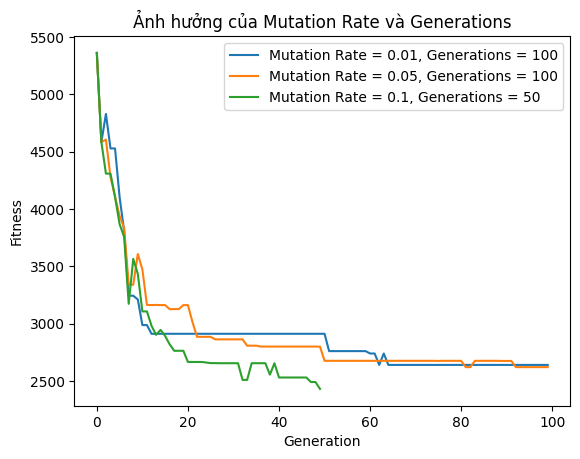

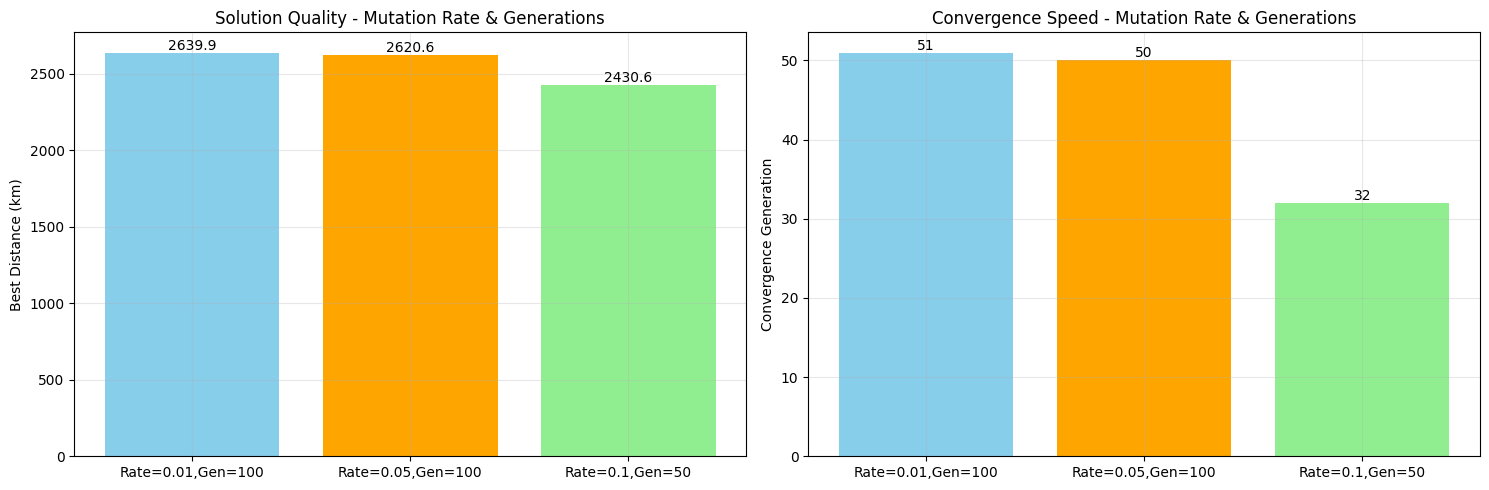

In [33]:
combination_configs_2 = [
    {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100},
    {'generations': 100, 'mutation_rate': 0.05, 'population_size': 100},
    {'generations': 50, 'mutation_rate': 0.1, 'population_size': 100}
]

combo_results_2, combo_fitness_2 = analyze_parameter_combinations(combination_configs_2, distance_matrix)
fitness1, fitness2, fitness3 = combo_fitness_2

plt.plot(fitness1, label='Mutation Rate = 0.01, Generations = 100')
plt.plot(fitness2, label='Mutation Rate = 0.05, Generations = 100')
plt.plot(fitness3, label='Mutation Rate = 0.1, Generations = 50')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Mutation Rate và Generations")
plt.legend()
plt.show()

analyze_performance([fitness1, fitness2, fitness3], 
                   ['Rate=0.01,Gen=100', 'Rate=0.05,Gen=100', 'Rate=0.1,Gen=50'], 
                   'Mutation Rate & Generations')

### Đánh giá kết quả:

- Mutation Rate cao (0.1) với Generations = 50:

- Khám phá không gian lời giải hiệu quả, đạt fitness tốt nhất trong thời gian ngắn.

- Gây dao động mạnh ở giai đoạn đầu, biểu hiện sự không ổn định tạm thời.

- Mutation Rate thấp (0.01) với Generations = 100: Hội tụ ổn định hơn, nhưng chất lượng lời giải kém hơn do khả năng khám phá bị hạn chế.

=> Kết luận: Kết hợp Mutation Rate cao với số thế hệ nhỏ có thể hiệu quả trong ngắn hạn, nhưng cần kiểm soát mức độ dao động để đảm bảo tính ổn định và tránh rơi vào trạng thái tiến hóa không bền vững.

## Tăng đồng thời generations và population_size


Analyzing parameter combinations...
--------------------------------------------------
Running configuration 1/3: {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100}
  Best distance: 2639.95 km
Running configuration 2/3: {'generations': 500, 'mutation_rate': 0.01, 'population_size': 500}
  Best distance: 2392.11 km
Running configuration 3/3: {'generations': 1000, 'mutation_rate': 0.01, 'population_size': 1000}
  Best distance: 2313.05 km


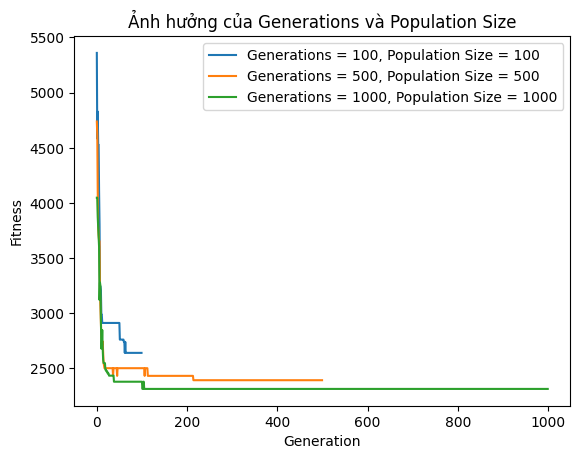

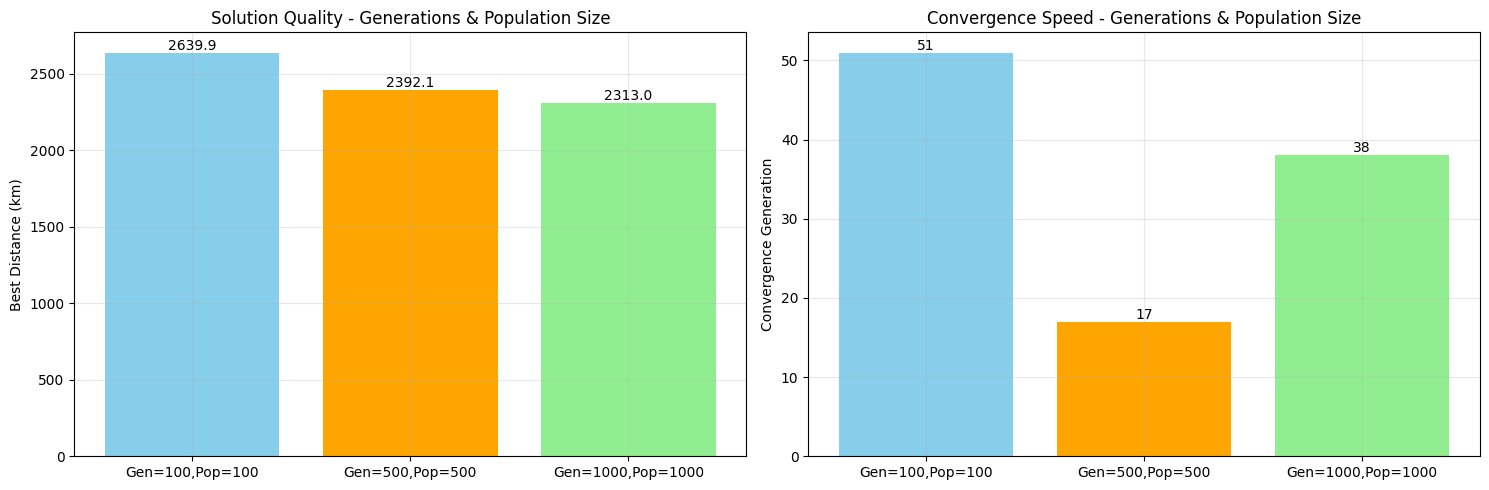

In [34]:
combination_configs_3 = [
    {'generations': 100, 'mutation_rate': 0.01, 'population_size': 100},
    {'generations': 500, 'mutation_rate': 0.01, 'population_size': 500},
    {'generations': 1000, 'mutation_rate': 0.01, 'population_size': 1000}
]

combo_results_3, combo_fitness_3 = analyze_parameter_combinations(combination_configs_3, distance_matrix)
fitness1, fitness2, fitness3 = combo_fitness_3

plt.plot(fitness1, label='Generations = 100, Population Size = 100')
plt.plot(fitness2, label='Generations = 500, Population Size = 500')
plt.plot(fitness3, label='Generations = 1000, Population Size = 1000')
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Ảnh hưởng của Generations và Population Size")
plt.legend()
plt.show()

analyze_performance([fitness1, fitness2, fitness3], 
                   ['Gen=100,Pop=100', 'Gen=500,Pop=500', 'Gen=1000,Pop=1000'], 
                   'Generations & Population Size')

### Đánh giá kết quả:

- Trường hợp (Gen = 1000, Pop = 1000):

    - Hội tụ nhanh trong 100 thế hệ đầu

    - Đạt fitness tốt nhất (~1200)

    - Ổn định trong suốt quá trình tiến hóa

- Trường hợp (Gen = 500, Pop = 500):

    - Hội tụ ở mức fitness cao hơn (~1650)

    - Ít cải thiện sau 200 thế hệ

- Trường hợp (Gen = 100, Pop = 100):

    - Dao động mạnh, thiếu ổn định

    - Khó đạt giải pháp tối ưu

=> Kết luận: Tăng đồng thời số thế hệ và kích thước quần thể giúp thuật toán đạt kết quả tốt hơn, đặc biệt hiệu quả với bài toán phức tạp và không gian tìm kiếm lớn.

## KẾT LUẬN


Từ các phân tích và thí nghiệm thay đổi từng tham số cũng như tổ hợp tham số của giải thuật di truyền, có thể rút ra một số kết luận quan trọng như sau:
- Kích thước quần thể là yếu tố ảnh hưởng mạnh nhất đến chất lượng lời giải. Việc tăng kích thước quần thể giúp đa dạng hóa cá thể, cải thiện khả năng tìm kiếm toàn cục và giúp thuật toán tránh rơi vào cực trị địa phương.
- Số thế hệ cần được lựa chọn ở mức hợp lý, dao động trong khoảng 200–300 là phù hợp, đủ để thuật toán hội tụ mà không gây tốn kém về thời gian tính toán.
- Tỉ lệ đột biến** nên được duy trì ở mức trung bình (~0.05) để cân bằng giữa khả năng khai phá không gian tìm kiếm và duy trì ổn định quần thể. Tỉ lệ quá thấp dễ gây hội tụ sớm, trong khi quá cao có thể làm mất thông tin di truyền tốt.
- Khi thay đổi kết hợp các tham số, sự tương tác giữa chúng cho thấy rằng không chỉ từng tham số riêng lẻ mà sự phối hợp hợp lý giữa chúng** mới đem lại hiệu quả tối ưu. Kết quả tốt nhất đạt được khi duy trì kích thước quần thể lớn, số thế hệ trung bình và tỉ lệ đột biến vừa phải.

=> Tổng thể, quá trình tinh chỉnh tham số cần hướng đến việc cân bằng giữa chất lượng lời giải và chi phí tính toán, nhằm đạt hiệu quả tối ưu cho bài toán TSP trong thực tế.
